In [1]:
%matplotlib inline
import cv2
import numpy as np
from matplotlib import pyplot as plt

import sys
sys.path.append('../scripts')
import util

green = (0, 255, 0)

### Read in an image, some anotation, plotting

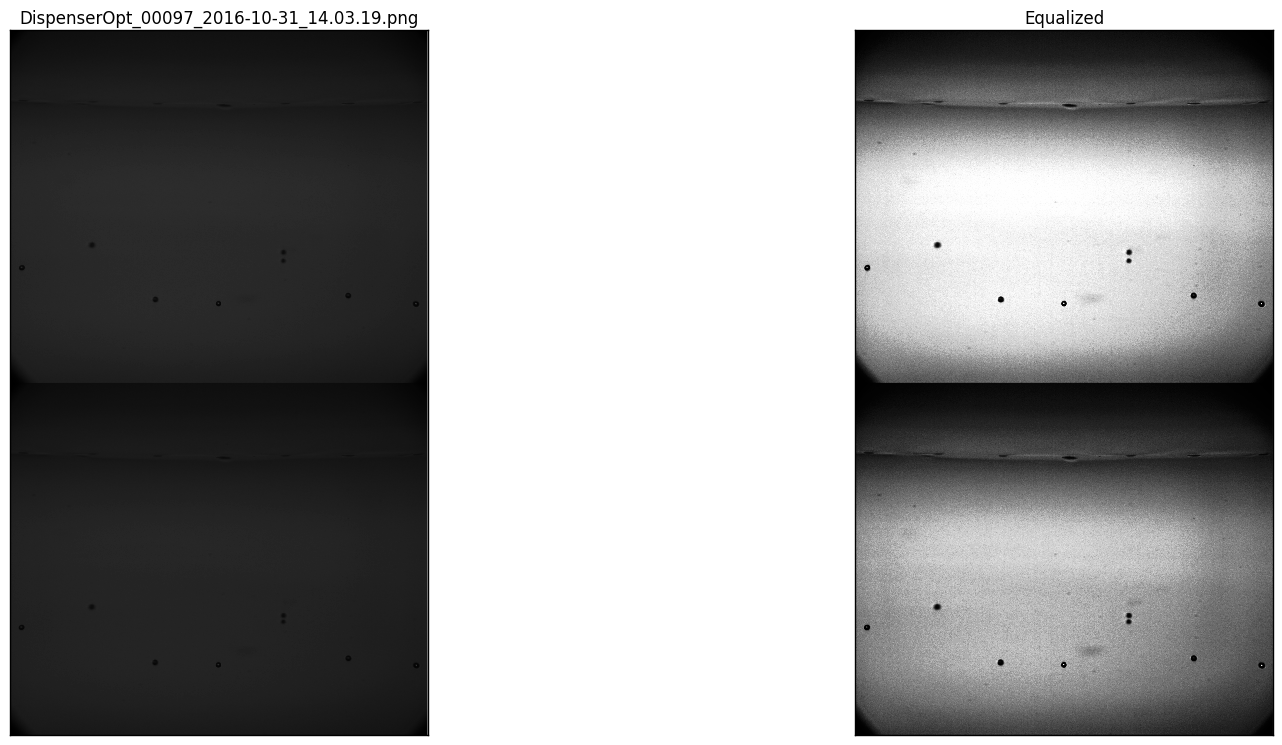

In [28]:
im = cv2.imread('../images/DispenserOpt_00097_2016-10-31_14.03.19.png',cv2.IMREAD_GRAYSCALE)
#im_gray = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)

im_equalized = cv2.equalizeHist(im)

rows, cols = im.shape
midX, midY = cols/2, rows/2

util.plot_imgs([(im, 'DispenserOpt_00097_2016-10-31_14.03.19.png'), (im_equalized, 'Equalized')], max_cols = 2)

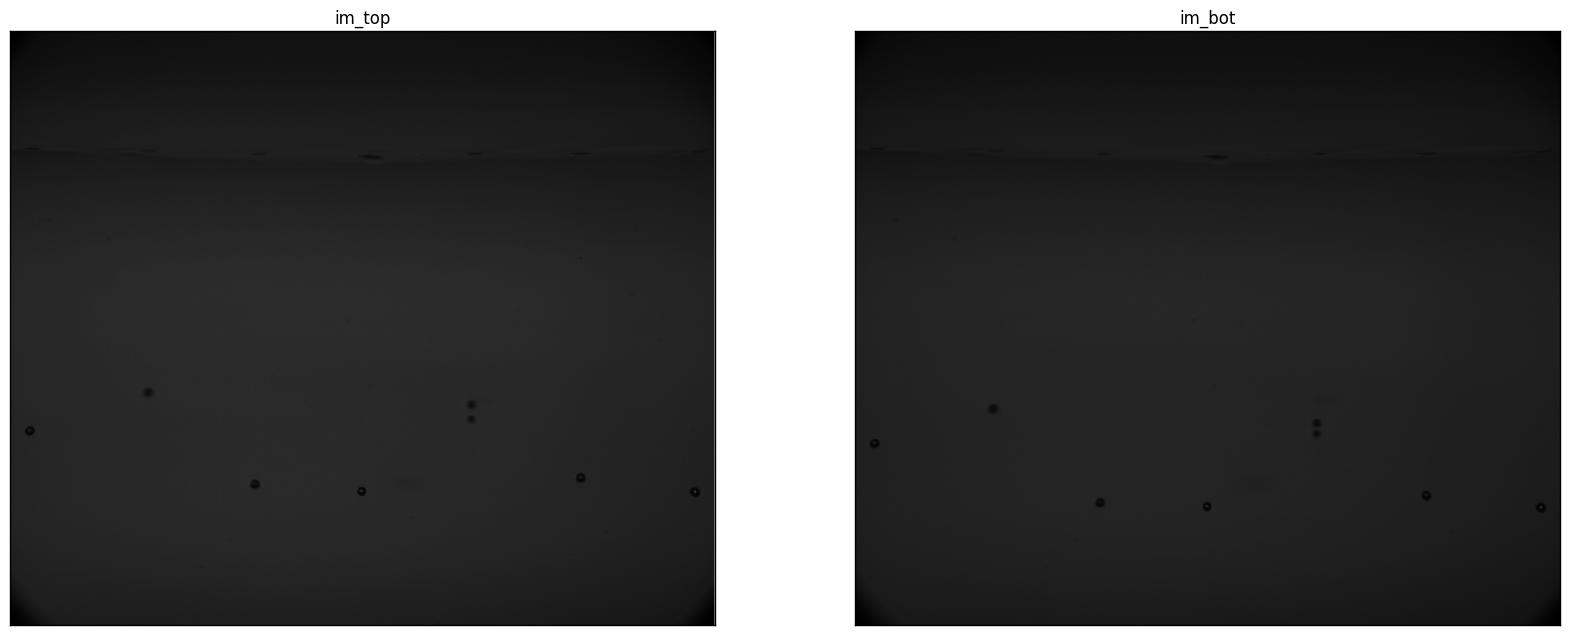

In [36]:
midX, midY = int(cols/2), int(rows/2)

im_top = im[1:midY, 1:cols]
im_bot = im[midY+1:rows, 1:cols]

util.plot_imgs([(im_top, 'im_top'), (im_bot, 'im_bot')], max_cols = 2)

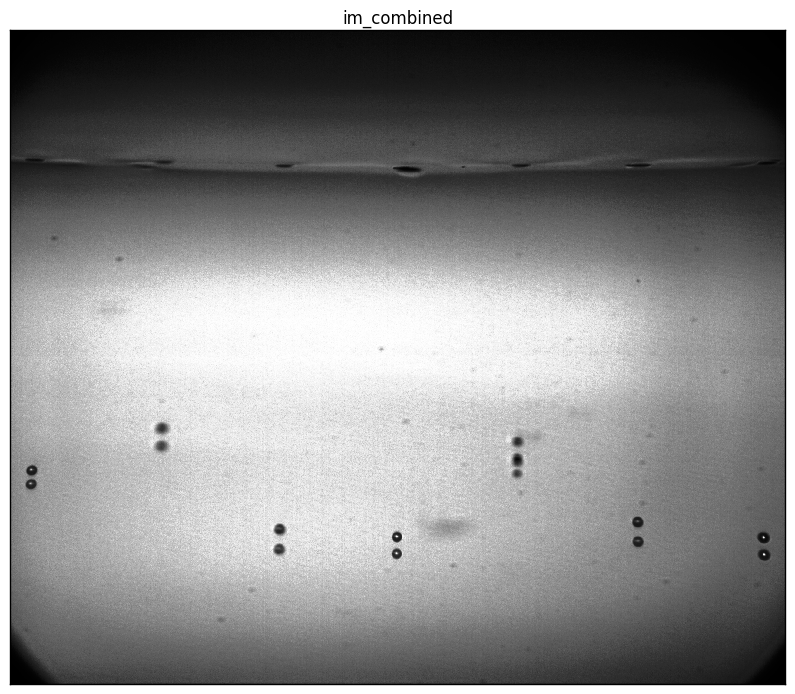

In [38]:
im_combined = im_top + im_bot
im_combined_equalized = cv2.equalizeHist(im_combined)

util.plot_imgs([(im_combined_equalized, 'im_combined')], max_cols = 2)

21.7704081633
21.7653061224


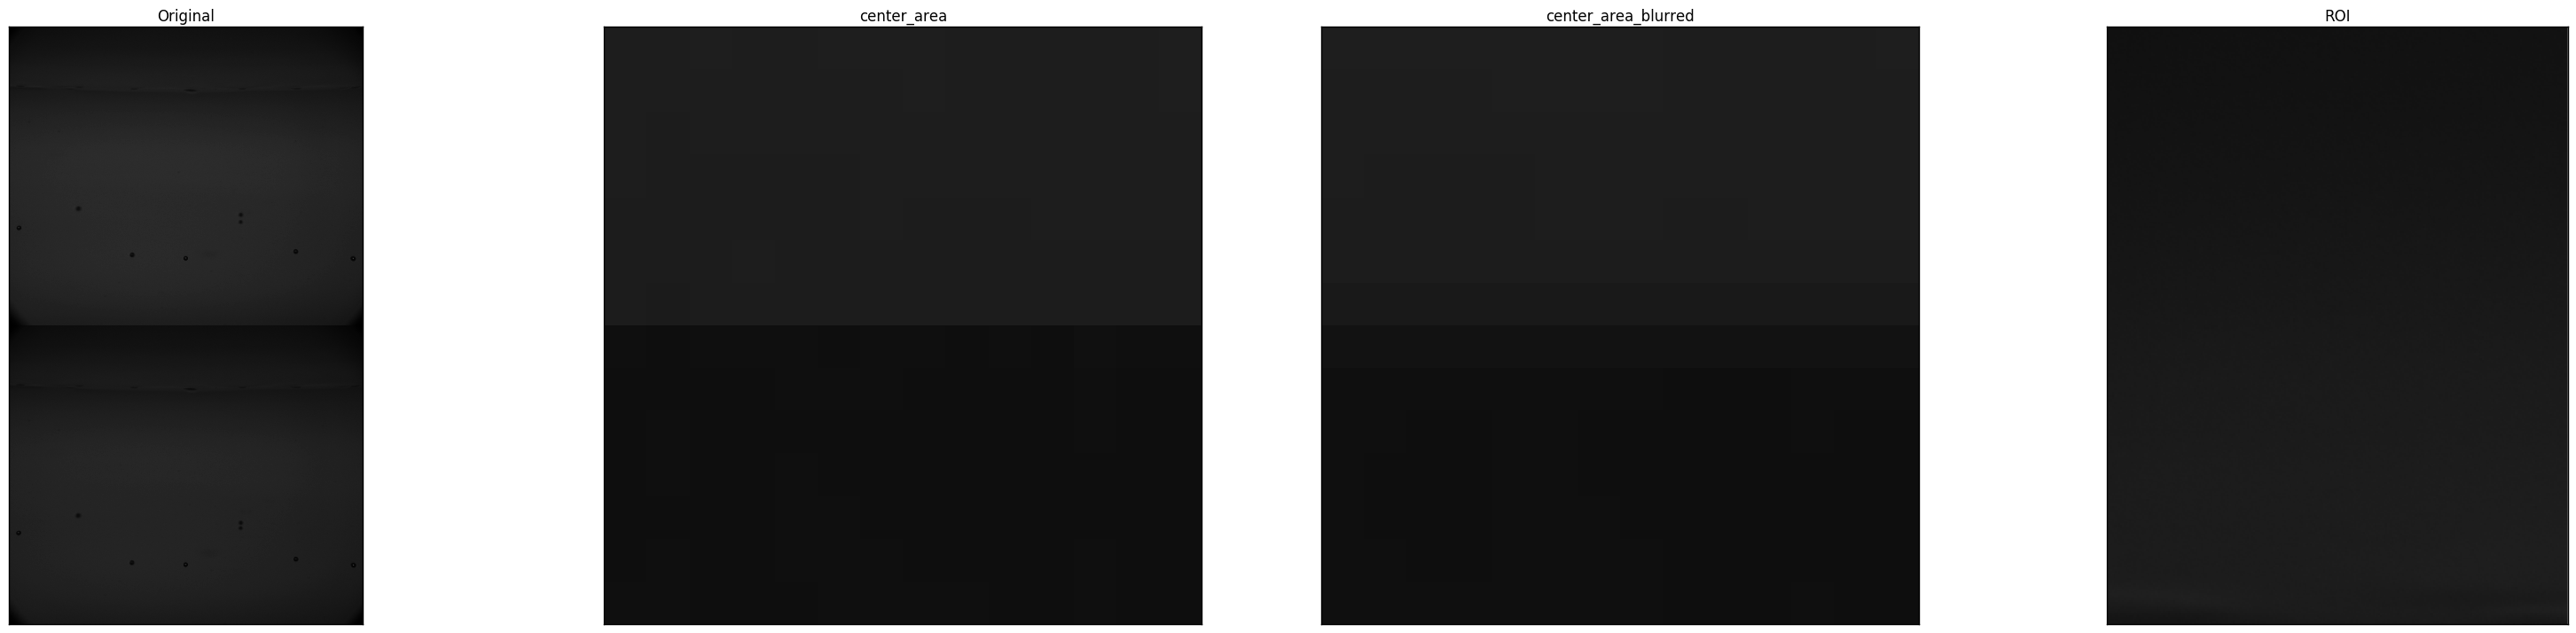

In [25]:
im_annotate = im.copy()
midX, midY = int(cols/2), int(rows/2)

center_area = im[midY-7:midY+7, midX-7:midX+7]
center_area_blurred = cv2.GaussianBlur(center_area, (3, 3), 0)

im_roi = im[99:449, 170:440]

green = (0, 255, 0)
cv2.line(im_annotate, (midX, midY-5), (midX, midY+5), green)
cv2.line(im_annotate, (midX-5, midY), (midX+5, midY), green)
#cv2.rectangle(img, (midY-7, midX-7), (midY+7, midX+7), green)

print(center_area.mean())
print(center_area_blurred.mean())

util.plot_imgs([(im_annotate,'Original'), (center_area, 'center_area'), 
            (center_area_blurred, 'center_area_blurred'), (im_roi, 'ROI')], max_cols = 4)

### Some thresholding...

### BLOBing...

1


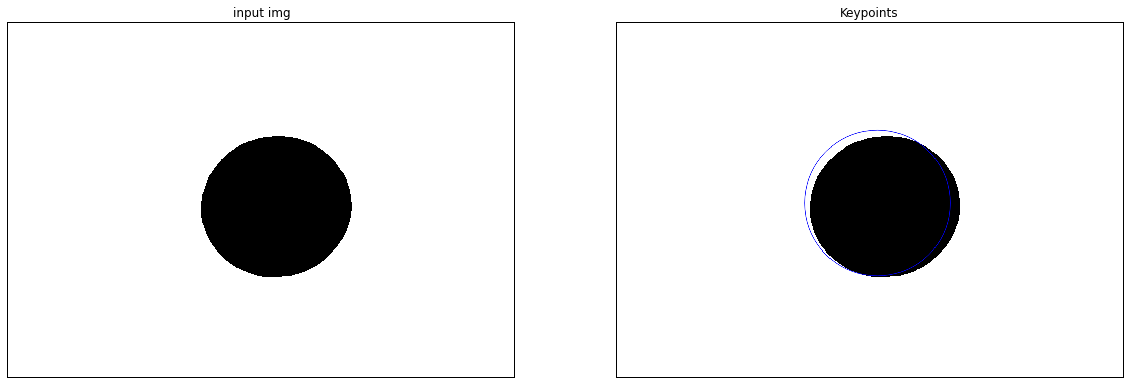

In [9]:
img_lst = []
#img = cv2.imread('/data/images/blob.jpg',cv2.IMREAD_GRAYSCALE)
img = cv2.imread('/data/tmp/process_img_636-511--300.png',cv2.IMREAD_GRAYSCALE)
img = img[100:800, 100:1100]

img_lst.append( (img,'input img') )

# Setup SimpleBlobDetector parameters.
params = cv2.SimpleBlobDetector_Params()

# Change thresholds
params.minThreshold = 1;
params.maxThreshold = 250;
 
# Filter by Area.
params.filterByArea = False
# params.minArea = 1500
 
# Filter by Circularity
params.filterByCircularity = False
# params.minCircularity = .1
 
# # Filter by Convexity
params.filterByConvexity = False
# params.minConvexity = 0.87
 
# # Filter by Inertia
params.filterByInertia = False
# params.minInertiaRatio = 0.9

params.filterByColor = False
params.filterByArea = True
params.minArea = 20.0
params.maxArea = 5000000.0

 
detector = cv2.SimpleBlobDetector_create(params)

# Detect blobs.
keypoints = detector.detect(img)
print len(keypoints)

if len(keypoints):
    # Draw detected blobs as red circles.
    # cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS ensures the size of the circle corresponds to the size of blob
    im_with_keypoints = cv2.drawKeypoints(img, keypoints, np.array([]), (0,0,255), cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
    img_lst.append( (im_with_keypoints,'Keypoints') )

# Show keypoints
util.plot_imgs(img_lst)

### Edge detection...

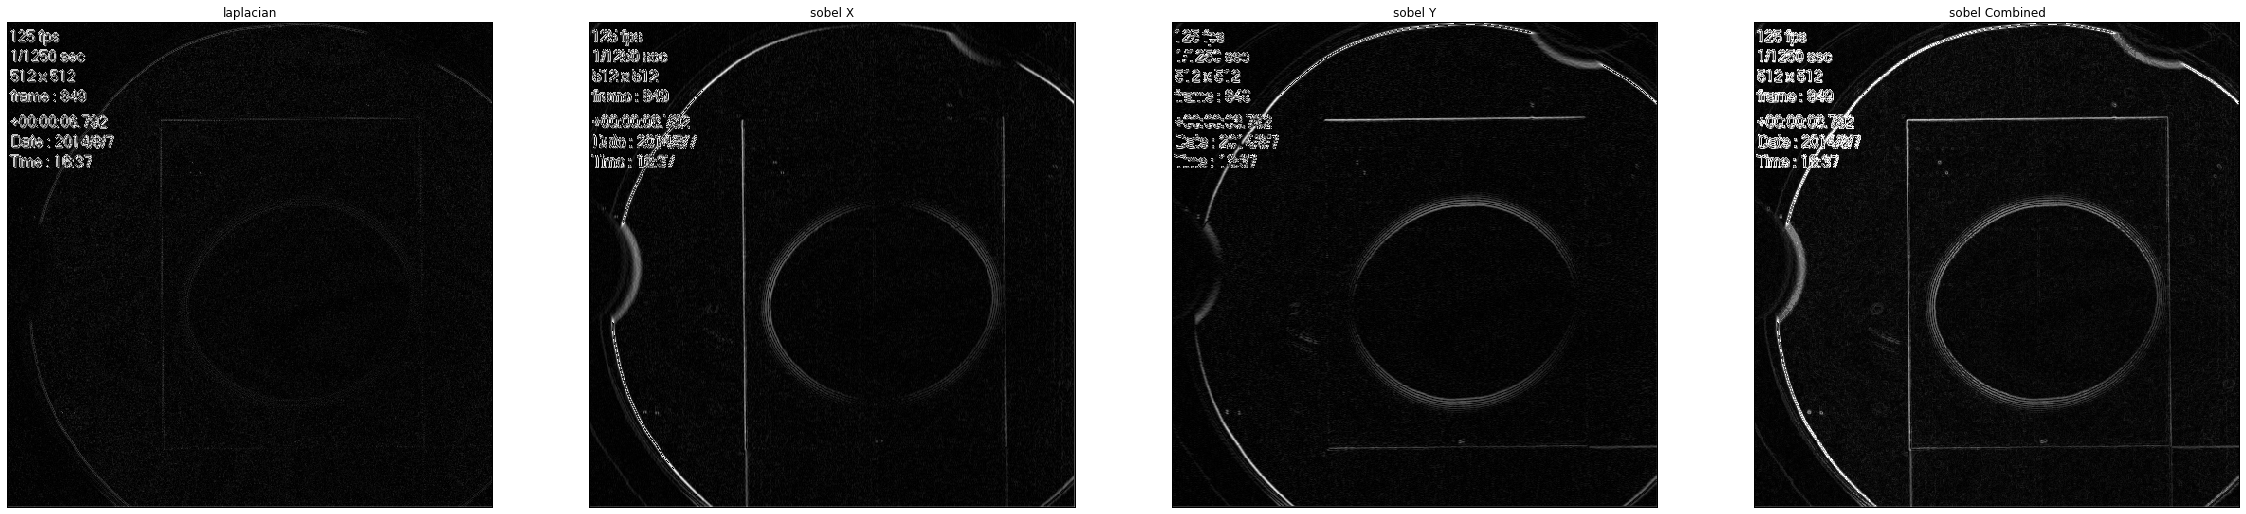

In [7]:
laplacian = cv2.Laplacian(img,cv2.CV_64F)
laplacian = np.uint8(np.absolute(laplacian))
sobelX = cv2.Sobel(img,cv2.CV_64F, 1, 0, ksize=3)
sobelX = np.uint8(np.absolute(sobelX))
sobelY = cv2.Sobel(img,cv2.CV_64F, 0, 1, ksize=3)
sobelY = np.uint8(np.absolute(sobelY))
sobelCombined = cv2.bitwise_or(sobelX, sobelY)
util.plot_imgs([(laplacian,'laplacian'), (sobelX, 'sobel X'), 
           (sobelY, 'sobel Y'), (sobelCombined, 'sobel Combined')], max_cols=4)

### Canny edge detection...

(529.8268877749371, 364.09339944954644)
(529.8262705851696, 364.08878809691504)
Info: Area and Contour Length
 * Contour[0] - Area (M_00) = 64734.50 - Area OpenCV: 64734.50 - Length: 952.93
 * Contour[1] - Area (M_00) = 64599.50 - Area OpenCV: 64599.50 - Length: 950.59


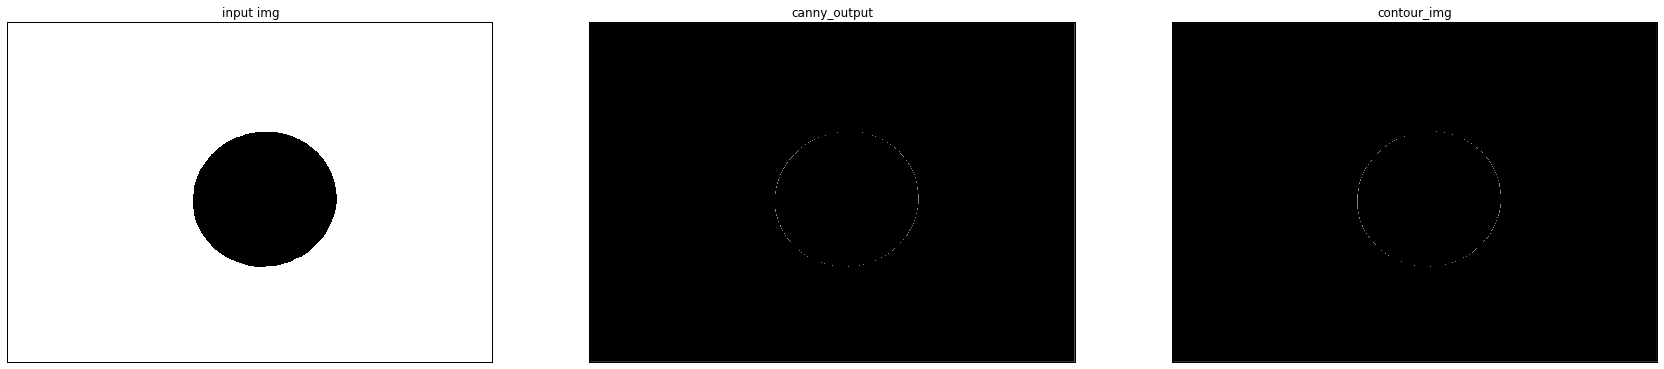

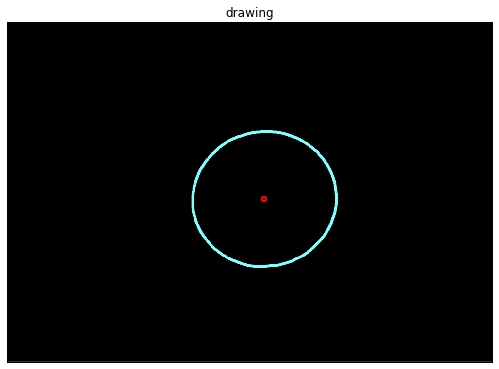

In [41]:
img_lst = []
#img = cv2.imread('/data/images/blob.jpg',cv2.IMREAD_GRAYSCALE)
img = cv2.imread('/data/tmp/process_img_636-511--300.png',cv2.IMREAD_GRAYSCALE)
img = img[100:800, 100:1100]
(rows, cols) = img.shape[:2]

img_lst.append( (img,'input img') )

canny_output = cv2.Canny(img, 50, 150, apertureSize=3, L2gradient=True)
img_lst.append( (canny_output,'canny_output') )

# Find contours
contour_img, contours, hierarchy = cv2.findContours(canny_output, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
img_lst.append( (contour_img,'contour_img') )

# Get the moments
mu_lst = []
for contour in contours:
    mu = cv2.moments(contour, False)
    mu_lst.append(mu)

#vector<Point2f> mc( contours.size() );
mc_lst = []
for i, contour in enumerate(contours):
    mu = mu_lst[i]
    mc = ( (mu['m10']/mu['m00']), (mu['m01']/mu['m00']) )
    print mc
    mc_lst.append(mc)

# Draw contours
#Mat drawing = Mat::zeros( canny_output.size(), CV_8UC3 );
drawing  = np.zeros((rows, cols, 3), np.uint8)
for i, contour in enumerate(contours):
    cv2.drawContours( drawing, contours, i, (128,255,255), 3, cv2.LINE_AA, hierarchy, 0 )
    cp = (int(mc_lst[i][0]), int(mc_lst[i][1]) )
    cv2.circle(drawing, cp, 4, (255,0,0),4)    

img_lst.append( (drawing,'drawing') )

#Calculate the area with the moments 00 and compare with the result of the OpenCV function
print("Info: Area and Contour Length");
for i, contour in enumerate(contours):
    area = cv2.contourArea(contour)
    arc_length = cv2.arcLength( contour, True )
    print(" * Contour[%d] - Area (M_00) = %.2f - Area OpenCV: %.2f - Length: %.2f" % (i, mu_lst[i]['m00'], area, arc_length) )


util.plot_imgs(img_lst)

### Color Channel Separation...

### SubImaging
